# Self-Driving Car Engineer Nanodegree


## Project 3: Behavioral Cloning


---

In [3]:
import csv
# import cv2
import keras
from keras.models import Sequential, model_from_json
from keras.layers.core import Activation, Dense, Dropout, Flatten, Lambda, Reshape
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf

print('Keras version: ', keras.__version__)
print('Tensorflow version: ', tf.__version__)

Keras version:  2.0.6
Tensorflow version:  1.2.1


In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras; import keras.backend
if keras.backend.backend() != 'tensorflow':
    raise BaseException("This script uses other backend")
else:
    keras.backend.set_image_dim_ordering('tf')
    print("Backend ok")

Using TensorFlow backend.


Backend ok


---
## Step 1: Load The Data

In [4]:
with open('data/udacity/driving_log.csv', newline='') as f:
    udacity_data = list(csv.reader(f, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))

print('total rows: ', len(udacity_data))
print(udacity_data[0])
udacity_data[1]

total rows:  8037
['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']


['IMG/center_2016_12_01_13_30_48_287.jpg',
 'IMG/left_2016_12_01_13_30_48_287.jpg',
 'IMG/right_2016_12_01_13_30_48_287.jpg',
 '0',
 '0',
 '0',
 '22.14829']

In [5]:

columns = udacity_data[0]
udacity_df = pd.read_csv('data/udacity/driving_log.csv', skiprows=[0], names=columns)

print('total rows: ', len(udacity_df))
udacity_df.head(n=10)

total rows:  8036


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236
5,IMG/center_2016_12_01_13_31_13_279.jpg,IMG/left_2016_12_01_13_31_13_279.jpg,IMG/right_2016_12_01_13_31_13_279.jpg,0.0,0.0,0.0,1.403993
6,IMG/center_2016_12_01_13_31_13_381.jpg,IMG/left_2016_12_01_13_31_13_381.jpg,IMG/right_2016_12_01_13_31_13_381.jpg,0.0,0.0,0.0,1.389892
7,IMG/center_2016_12_01_13_31_13_482.jpg,IMG/left_2016_12_01_13_31_13_482.jpg,IMG/right_2016_12_01_13_31_13_482.jpg,0.0,0.0,0.0,1.375934
8,IMG/center_2016_12_01_13_31_13_584.jpg,IMG/left_2016_12_01_13_31_13_584.jpg,IMG/right_2016_12_01_13_31_13_584.jpg,0.0,0.0,0.0,1.362115
9,IMG/center_2016_12_01_13_31_13_686.jpg,IMG/left_2016_12_01_13_31_13_686.jpg,IMG/right_2016_12_01_13_31_13_686.jpg,0.0,0.0,0.0,1.348435


---

## Step 2: Dataset Summary & Exploration

---



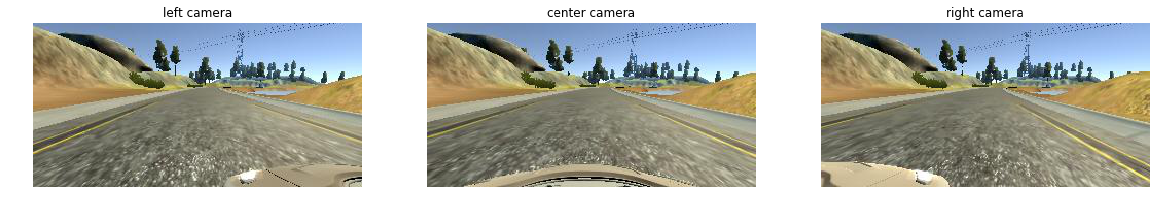

In [6]:
## Preview random set of images from each camera angle

# Display visualizations in the notebook
%matplotlib inline

index = random.randint(0, len(udacity_data))
img_dir = 'data/udacity/'

center_img = mpimg.imread(img_dir + udacity_data[index][0])
left_img = mpimg.imread(img_dir + udacity_data[index][1])
right_img = mpimg.imread(img_dir + udacity_data[index][2])

plt.figure(figsize=(20,5))

plt.subplot2grid((1, 3), (0, 0));
plt.axis('off')
plt.title('left camera')
plt.imshow(left_img, cmap="gray")

plt.subplot2grid((1, 3), (0, 1));
plt.axis('off')
plt.title('center camera')
plt.imshow(center_img, cmap="gray")

plt.subplot2grid((1, 3), (0, 2));
plt.axis('off')
plt.title('right camera')
plt.imshow(right_img, cmap="gray")

---
### Pre-process the Data Set

In [7]:
## Create training and validation sets *CENTER ONLY*

X_train_center = udacity_df.center.tolist()
y_train = udacity_df.steering.tolist()

X_train, X_valid, y_train, y_valid = \
                train_test_split(X_train_center, y_train, test_size=0.2, random_state=0)

In [8]:

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_valid = len(X_valid)

# # TODO: Number of testing examples.
# n_test = len(X_test)

# # TODO: What's the shape of a traffic sign image?
# image_shape = X_train.shape[1:]

# # TODO: How many unique classes/labels there are in the dataset.
# labels_index = np.unique(y_train)
# n_labels = len(labels_index)

print("Number of training examples: ", n_train)
print("Number of validation examples: ", n_valid)
print("----------\nVerify Totals: {} should equal {} ".format((n_train+n_valid), len(udacity_df)))
# print("Number of testing examples =", n_test)
# print("Image data shape =", image_shape)
# print("Number of labels/classes =", n_labels)

Number of training examples:  6428
Number of validation examples:  1608
----------
Verify Totals: 8036 should equal 8036 


In [20]:
# center = udacity_df.center.tolist()
# # left = data.left.tolist()
# # right = data.right.tolist()
# steering = udacity_df.steering.tolist()

---
### Augmentation

Generates batches of tensor image data that is augmented based on a chosen set of tranformation parameters (e.g. rotation, shift, shear, zoom).

In [12]:
## Apply affine and color transformations 

import keras
from keras.preprocessing.image import ImageDataGenerator

# Transformations applied to RBG training images
datagen = keras.preprocessing.image.ImageDataGenerator(
    zca_whitening=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15,
    channel_shift_range=0.1,
    fill_mode='nearest',
    horizontal_flip=False,
    vertical_flip=False
)


Using TensorFlow backend.


---
## Model Architecture
---

### Operations

### Generator

In [9]:
def generator(images, angles):
    images, angles = shuffle(images, angles)
    X = []  # images batch
    y = []  # angles batch
    while True:
        for i in range(len(angles)):
            img_path = IMG_DIR + images[i]
            image = mpimg.imread(img_path.strip())
            X.append(image)
            y.append(angles[i])
            if len(y) == batch_size:
                yield (np.array(X), np.array(y))
                X, y = ([],[])
                images, angles = shuffle(images, angles)

### Model

In [16]:
## Global variables and parameters

LOG_DIR = ".logs"
MODEL_DIR = ".models"
IMG_DIR = "data/udacity/"

epochs = 1
batch_size = 128

mu = 0             # normalized mean
sigma = 0.1        # normalized stdev
lr = 1e-4          # learning rate
reg = l2(1e-5)     # L2 reg
drop = 0.5

strides = (2, 2)
act = 'relu'
default_pad = 'same'

In [17]:
shape_in = (160, 320, 3)
crop = ((70, 26), (0, 0))  # (top, bottom), (left, right)
shape_diff = ( (shape_in[0]-(crop[0][0]+crop[0][1])), shape_in[1], shape_in[2] )
shape_out = (64, 64 ,3)

In [18]:
shape_diff

(64, 320, 3)

In [19]:
model = Sequential()
model.add(Lambda(lambda x: x/255 - 0.5, input_shape=shape_in))
# model.add(Cropping2D(cropping=crop))
# model.add(Reshape(shape_out, input_shape=shape_diff))
model.add(Convolution2D(24, 5, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
model.add(Convolution2D(36, 5, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
model.add(Convolution2D(48, 5, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Convolution2D(64, 3, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
model.add(Convolution2D(64, 3, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())
model.add(Dense(80, kernel_regularizer=reg))
model.add(Dropout(drop))
model.add(Dense(40, kernel_regularizer=reg))
model.add(Dropout(drop))
model.add(Dense(16, kernel_regularizer=reg))
model.add(Dropout(drop))
model.add(Dense(10, kernel_regularizer=reg))
model.add(Dense(1))

In [20]:
# Compile and preview the model
model.compile(optimizer=Adam(lr=lr), loss='mean_squared_error', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 80, 160, 24)       1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 40, 80, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 40, 48)        43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 20, 64)        27712     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 5, 10, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
__________

In [21]:
## Train and save the model

train_gen = generator(X_train, y_train)
val_gen = generator(X_valid, y_valid)

train_steps = len(X_train) // batch_size
val_steps = len(X_valid) // batch_size

model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=epochs, validation_data=val_gen, validation_steps=val_steps)

print('\nDone Training')

# Save model and weights
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save("model.h5")
print("Saved model to disk")

Epoch 1/1
50/50 [==============================] - 28s - loss: 0.0240 - acc: 0.5363 - val_loss: 0.0186 - val_acc: 0.5495
Done Training
Saved model to disk
